### Battery State of Charge (SoC) Estimation Project. Made by Tiuterev Mikhail


This notebook provides an in-depth overview of my research, showcasing the methodology and results of estimating the State of Charge (SoC) for battery cells. The work is organized into several parts, each aimed at building an understanding of the SoC estimation process and the challenges encountered. This summary is designed to offer insight into the steps taken and the key results obtained.

The notebook consists of the following sections:

##### 1. **Data Collection**
   This section primarily serves as a technical setup, providing the necessary data and code to facilitate the subsequent stages of the analysis. While not central to the main findings, this part ensures the data foundation is established and functional.

##### 2. **Potential Drop Analysis**
   In this section, I analyze the potential drop to gain a deeper understanding of the problem and identify unresolved issues. A key observation here is that the initial voltage \( V[0] \) does not match the open-circuit voltage \( U_{ocp}(SoC[0]) \), even when the initial current \( I[0] = 0 \). Additionally, estimating the Ohmic resistance proved to be challenging, prompting the need for alternative approaches to SoC estimation.

##### 3. **SoC Derivative Estimation via Current**
   This part examines the relationship between current and the derivative \( d(\text{SoC}, \text{step}) \). The results reveal a linear dependency, with a consistent coefficient across most datasets, save for one outlier. Analysis of this outlier indicated a significant discrepancy in charge exchange between charging and discharging (by an order of magnitude), suggesting potential data integrity issues with this file, which was consequently excluded from further analysis. The derivative \( d(d(\text{SoC}, \text{step}), \text{Current}) \) was found to be constant across valid datasets.

##### 4. **Initial SoC Estimation**
   A critical result from the previous section was the realization that, given an SoC value at any point, we could reconstruct the SoC over time using current values alone. The challenge, therefore, becomes estimating the initial SoC \( \text{SoC}[0] \). I analyzed the dependency between the voltage difference \( \text{Voltage} - U_{ocp}(\text{SoC}_{\text{estim}}) \) and the initial SoC. Here, \( \text{SoC}_{\text{estim}} \) represents an integral over \( \text{Current} \times d(d(\text{SoC}, \text{step}), \text{Current}) + \text{SoC}[0] \). Both L1 and L2 error functions were tested, with the L2 function proving more accurate.

##### 5. **LSTM Model for \( U_{ocp} \) Estimation**
   This final section explores the application of an LSTM model to estimate \( U_{ocp} \) using voltage and current inputs. While the model successfully predicted \( U_{ocp} \), it was computationally intensive and yielded an error of approximately 20%, which is higher than that observed through the analytical approaches discussed in earlier sections.



### 1. **Data Collection**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from importing_functions import (
    load_excel_files, 
    get_OCV_data, 
    calculate_and_plot_resistive_voltage_drop,
    get_expanded_HPPC_data
)

Loading all the excel files from the current directory and everywhere below

In [2]:
# Define the base directory
base_dir = os.getcwd()

# Load the Excel files
dataframes = load_excel_files(base_dir)

# Print the names of the loaded DataFrames
# for file_name, df in dataframes.items():
#     print(f"Loaded {file_name} with shape {df.shape}")

test_file.xlsx
Cha_Dis_OCV_SOC_Data.xlsx
out.xlsx
EVE_HPPC_1_25degree_DSG-injectionTemplate.xlsx
EVE_HPPC_1_25degree_CHG-injectionTemplate.xlsx
GenerateTestData_S1_DAY0to4.xlsx
GenerateTestData_S1_DAY4to7.xlsx
GenerateTestData_S3_DAY0to4.xlsx
GenerateTestData_S3_DAY4to7.xlsx
GenerateTestData_S2_DAY0to4.xlsx
GenerateTestData_S2_DAY4to7.xlsx
GenerateTestData_S4_DAY4to7.xlsx
GenerateTestData_S4_DAY0to4.xlsx
Cha_Dis_OCV_SOC_Data.xlsx
Cha_Dis_OCV_SOC_Data.xlsx


To streamline the analysis, all data files have been organized into three categories:

**OCV Files (Open Circuit Voltage):**  
These files capture the open circuit voltage (OCV) as a function of the State of Charge (SoC). It’s essential to note that during charging and discharging, the value of \( U_{ocp} \) (open-circuit potential) differs. This variation must be accounted for in the analysis to ensure accurate SoC estimation.

**HPPC Files (Hybrid Pulse Power Characterization):**  
This category includes two files, one for the charging process and one for the discharging process. The HPPC test applies current pulses to the battery and measures the resulting voltage response, providing valuable information on the battery’s dynamic behavior and internal resistance characteristics.

**TestData Files:**  
These files document the full charge-discharge cycles of the battery. They serve as the primary dataset for analyzing the SoC dynamics throughout typical operating cycles, supporting the estimation and validation of the SoC model.




In [3]:
# Find the first file name containing "OCV"
ocv_file = next((file for file in dataframes.keys() if "OCV" in file), None)
# Find all file names containing "HPPC" and "TestData"
hpc_files = [file for file in dataframes.keys() if "HPPC" in file]
test_files = [file for file in dataframes.keys() if "TestData" in file]

# Check if an OCV file was found and call get_OCV_data
if ocv_file:
    data_OCV = get_OCV_data(ocv_file, dataframes)
else:
    print("No file with 'OCV' found.")


Collecting the file data using the side function. 

In [6]:
# Charging HPPC
chg_file = next(file for file in hpc_files if "CHG" in file)
data_HPPC_1_expanded = get_expanded_HPPC_data(chg_file, dataframes, data_OCV)
# Discharging HPPC
dhg_file = next(file for file in hpc_files if "DSG" in file)
data_HPPC_2_expanded = get_expanded_HPPC_data(dhg_file, dataframes, data_OCV)
# Test File
data_HPPC_3_expanded = get_expanded_HPPC_data(test_files[1], dataframes, data_OCV)
#np.savez('data_output_exp3.npz', Step=data_HPPC_3_expanded['Step'], Voltage=data_HPPC_3_expanded['Voltage'], Current=data_HPPC_3_expanded['Current'], SOC=data_HPPC_3_expanded['SOC'], U_ocp=data_HPPC_3_expanded['U_ocp'],U_cell_without_U_ocp=data_HPPC_3_expanded['U_cell_without_U_ocp'],Voltage_to_SOC=data_HPPC_3_expanded['Voltage_to_SOC'])

# data_HPPC_4_expanded = get_expanded_HPPC_data(test_files[4], dataframes, data_OCV)
# data_HPPC_5_expanded = get_expanded_HPPC_data(test_files[5], dataframes, data_OCV)


h:\My Drive\вуз\Masters\3 semester\Hackathon Huawei\importing_functions.py:144: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  step_values = hppc_df_cleaned['Step'].fillna(0).infer_objects(copy=False).values
h:\My Drive\вуз\Masters\3 semester\Hackathon Huawei\importing_functions.py:144: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  step_values = hppc_df_cleaned['Step'].fillna(0).infer_objects(copy=False).values


Print the U_ocp function

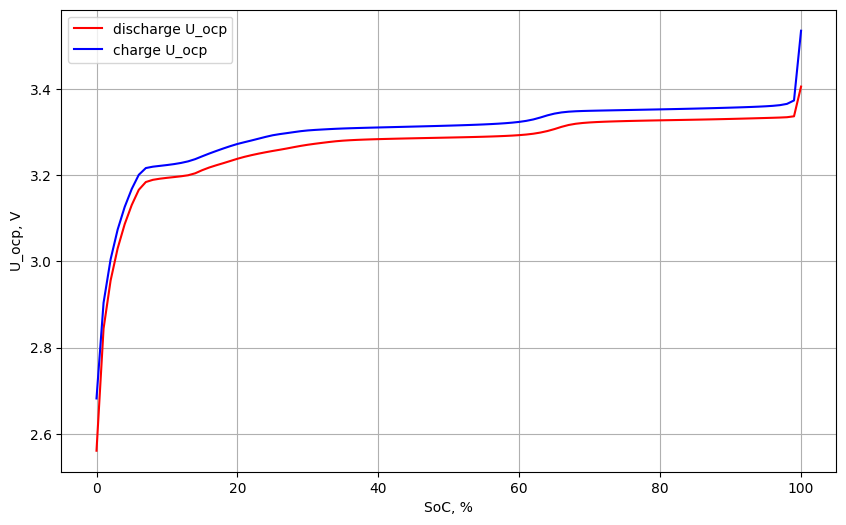

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data_OCV['discharge']['SOC'], data_OCV['discharge']['U'], color='red', label='discharge U_ocp')
plt.plot(data_OCV['charge']['SOC'], data_OCV['charge']['U'], color='blue', label='charge U_ocp')
plt.xlabel('SoC, %')
plt.ylabel('U_ocp, V')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

### 2. **Potential Drop Analysis**

To begin the voltage analysis, we split the total voltage into three components, based on the assumption that it consists of the following parts: \( U_{ocp} \), \( U_{R} \), and \( U_{diff} \).

1. **\( U_{ocp} \)**  
   This is the open-circuit potential, which occurs at the interface between the electrolyte and electrode. The relationship \( U_{ocp}(\text{SoC}) \) is defined in a reference file and depends on the State of Charge (SoC). This component reflects the equilibrium potential when no current flows through the system.

2. **\( U_{R} \)**  
   This represents the potential drop due to ohmic resistance within the battery. It is observed as a sudden increase in voltage when current is applied, indicating an immediate response to the resistance of conductive materials in the battery. The presence of \( U_{R} \) is due to this instantaneous voltage change upon current application, often seen as a step in the voltage signal.

3. **\( U_{diff} \)**  
   This is the diffusion-related potential loss, resulting from the non-uniform distribution of charged particles in the electrolyte. After current application, these particles gradually re-distribute until reaching equilibrium, which manifests as a gradual relaxation in voltage. This relaxation process reflects the time needed for ions to return to a uniform distribution in the electrolyte.

By separating the total voltage into these three components, we can analyze each part independently, allowing for a clearer understanding of the voltage dynamics and their impact on the SoC estimation.


#### \( U_{R} \) estimation

To analyze the potential drop during the pulse power characterization, we need a function that detects pulses in the current and calculates the corresponding voltage difference.

##### Approach

1. **Pulse Detection**  
   Identify the moments when a current pulse occurs. This can be done by checking for significant changes in current values, which indicate the start and end of a pulse.

2. **Voltage Difference Calculation**  
   For each detected pulse, record the voltage at the beginning and at the end of the pulse. The difference between these two voltage values represents the potential drop during the pulse.


##### Discharging process

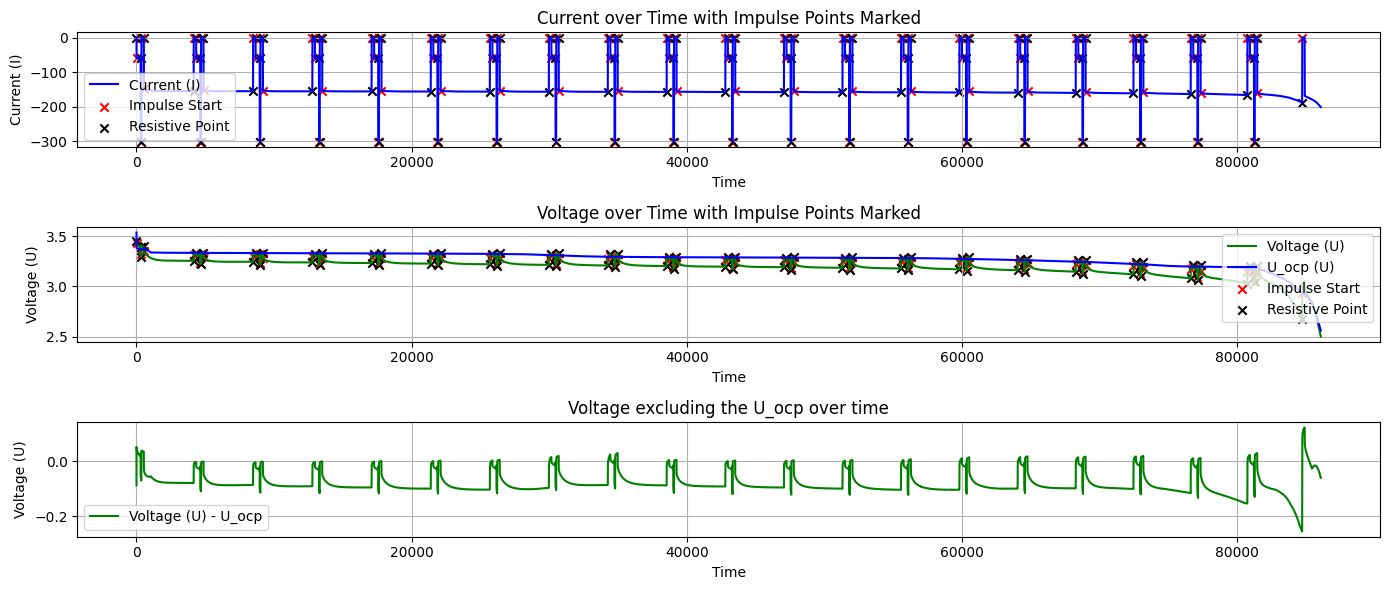

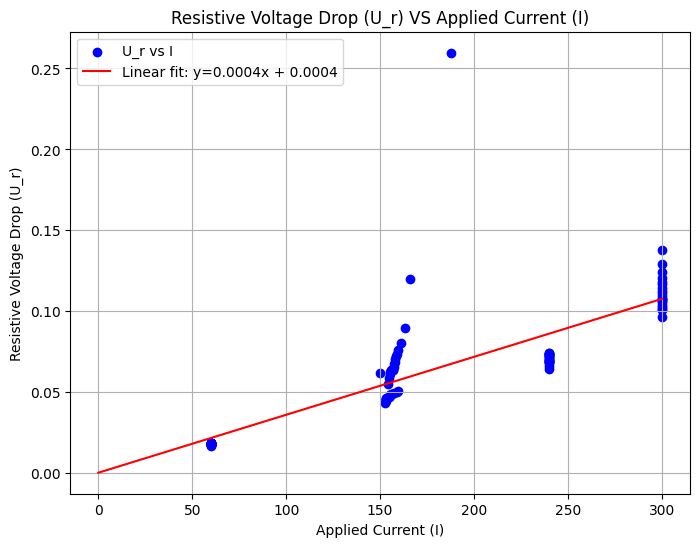

In [8]:
file = data_HPPC_2_expanded
# Calculate I_values and U_r_values
_, _ = calculate_and_plot_resistive_voltage_drop(file['Step'], file['Current'], file['Voltage'],file['U_ocp'])

##### Charging process

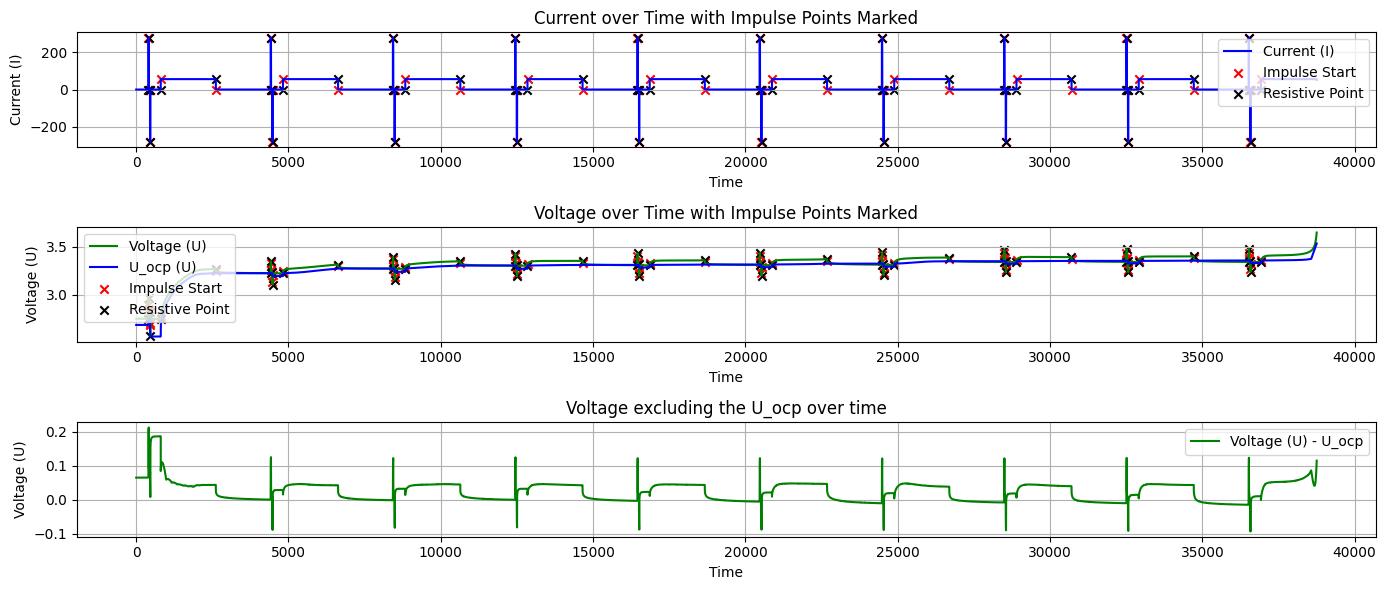

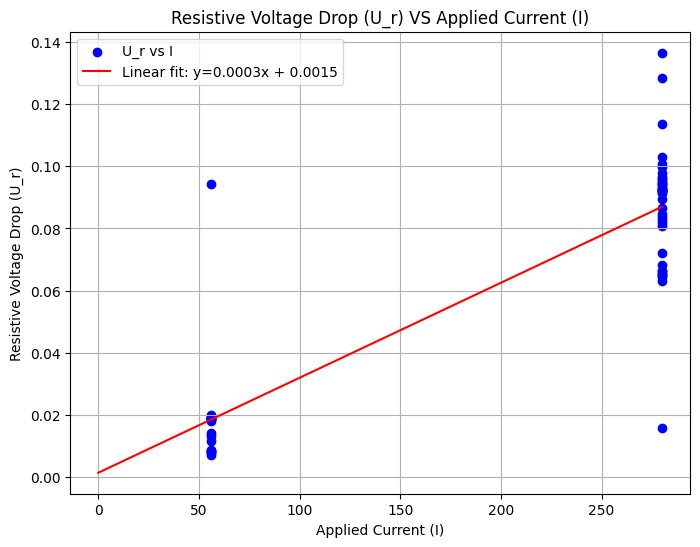

In [9]:
file = data_HPPC_1_expanded
# Calculate I_values and U_r_values
_, _ = calculate_and_plot_resistive_voltage_drop(file['Step'], file['Current'], file['Voltage'],file['U_ocp'])

##### Analysis on Test Data example

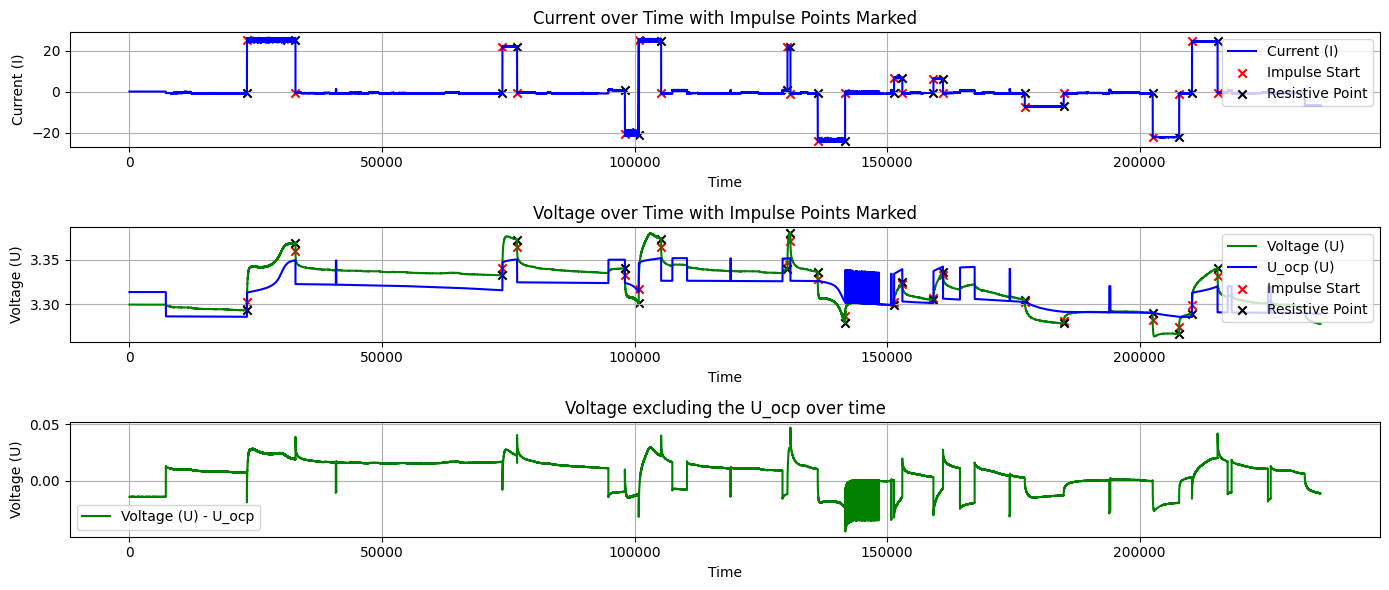

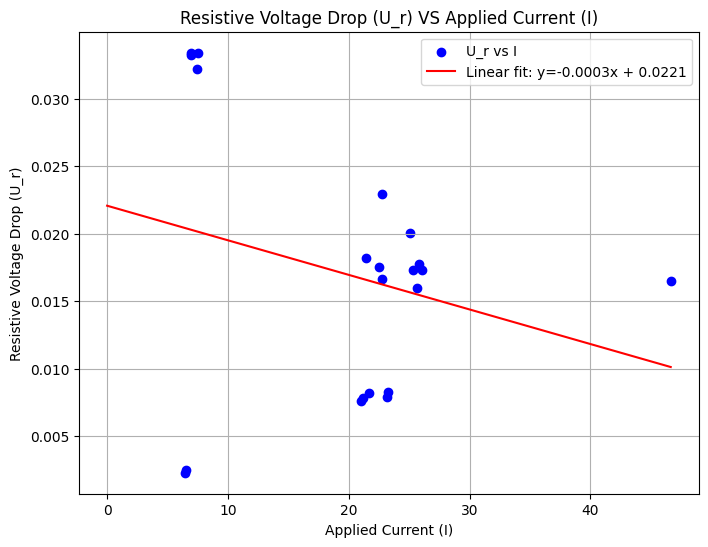

In [10]:
file = data_HPPC_3_expanded
# Calculate I_values and U_r_values
_, _ = calculate_and_plot_resistive_voltage_drop(file['Step'], file['Current'], file['Voltage'],file['U_ocp'])

##### Result
Our analysis reveals a linear dependence between the voltage drop and the current applied, but only at very low current levels. As the current increases, the data points become more scattered, making it difficult to extract a reliable pattern or trend. 


#### \( U_{diff} \) estimation

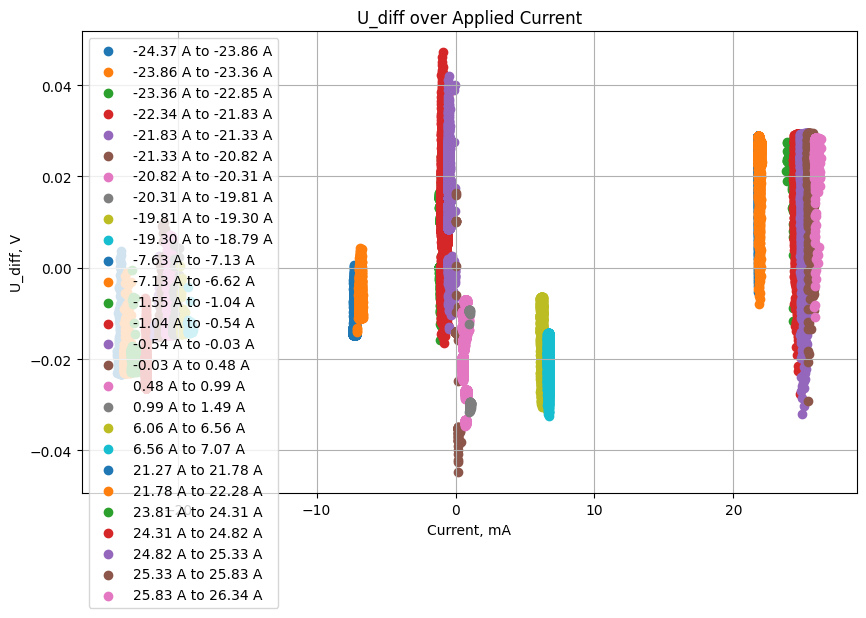

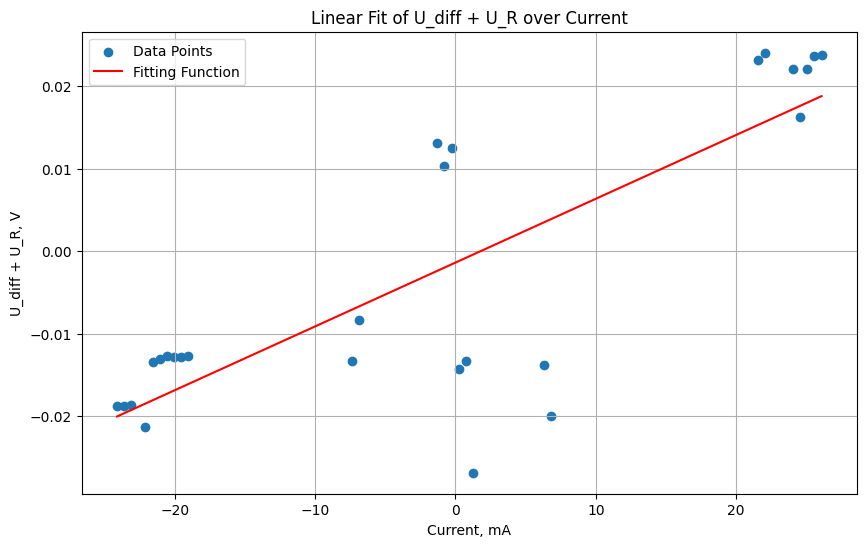

Slope: 0.000773492065470956
Intercept: -0.0013924235896249867


In [11]:
file = data_HPPC_3_expanded

# Calculate y_plot and x_plot
y_plot = file['Voltage'] - file['U_ocp']
x_plot = file['Current']

# Define the number of bins you want
num_bins = 100  # Adjust this number based on your needs

# Create bins based on the data
counts, bins = np.histogram(x_plot, bins=num_bins)

# Digitize the current values to find out which bin each value belongs to
bin_indices = np.digitize(x_plot, bins)
# Initialize x_coord and y_coord
x_coord = []
y_coord = []
# Plot each bin separately where counts are > 10
plt.figure(figsize=(10, 6))
for i in range(1, len(bins)):
    if counts[i-1] > 10:
        bin_mask = bin_indices == i
        x_coord.append((bins[i-1] + bins[i]) / 2)
        y_coord.append(np.mean((y_plot[bin_mask])))
        # Check if any 'Current' values in this bin are zero
        if any(file['Current'][bin_mask] == 0):
            zero_current_bin = i  # Store the bin index where Current = 0

        plt.scatter(x_plot[bin_mask], y_plot[bin_mask], label=f'{bins[i-1]:.2f} A to {bins[i]:.2f} A')

plt.xlabel('Current, mA')
plt.ylabel('U_diff, V')
plt.title('U_diff over Applied Current')
plt.legend()
plt.grid(True)
plt.show()

# Perform linear fit passing through (0,0)
coefficients = np.polyfit(x_coord, y_coord, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Plot x_coord and y_coord with the fitting function
plt.figure(figsize=(10, 6))
plt.scatter(x_coord, y_coord, label='Data Points')
plt.plot(x_coord, np.polyval(coefficients, x_coord), color='red', label='Fitting Function')
plt.xlabel('Current, mA')
plt.ylabel('U_diff + U_R, V')
plt.title('Linear Fit of U_diff + U_R over Current')
plt.legend()
plt.grid(True)
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)



Given that we observe an approximately linear relationship between current and \( U_{diff} \), we can refine our analysis by focusing on sections of the data where the voltage slope is relatively flat. These points provide more stable conditions, allowing for a more accurate estimation of \( U_{diff} \).


#### **\( U_{ocp} \)** estimation

Define the U_ocp(SoC) and reverse function

In [12]:
# Interpolation functions for charge and discharge using OCV data and also inverted ones
interp_func_charge = interp1d(data_OCV['charge']['SOC'], data_OCV['charge']['U'], 
                                bounds_error=False, fill_value="extrapolate")
interp_func_discharge = interp1d(data_OCV['discharge']['SOC'], data_OCV['discharge']['U'], 
                                    bounds_error=False, fill_value="extrapolate")
interp_func_charge_inv = interp1d(data_OCV['charge']['U'], data_OCV['charge']['SOC'],
                            bounds_error=False, fill_value="extrapolate")
interp_func_discharge_inv = interp1d( data_OCV['discharge']['U'], data_OCV['discharge']['SOC'],
                                bounds_error=False, fill_value="extrapolate")

Next, we proceed to plot the voltage from the TestData file alongside \( U_{ocp}(\text{SoC}) \) for each data point, distinguishing between the charge and discharge processes. This visualization uses color indicators to clarify which \( U_{ocp} \) values are relevant for each condition:

- **Green**: Indicates the \( U_{ocp} \) values that should be applied based on the current direction (charging or discharging).
- **Red**: Marks \( U_{ocp} \) values that should not be used for this point in the process.
- **Black**: Represents points where no current is applied, indicating a state of equilibrium.

By plotting these indicators, we can clearly see the correspondence between the actual voltage, and the expected \( U_{ocp} \) values for charging and discharging phases, enabling us to verify and validate the SoC estimation.


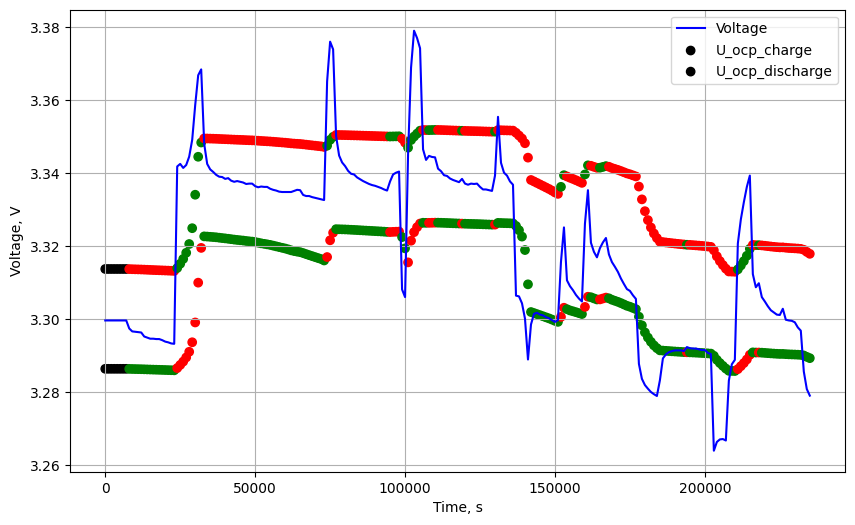

In [13]:
file = data_HPPC_3_expanded
# 3. Plot U_r over applied I
y_plot = file['Voltage'] 
x_plot = file['Step']

# Create a mask for the color based on the sign of file["Indicator"]
colors = np.where(file["Indicator"] == 1, 'green', np.where(file["Indicator"] == -1, 'red', 'black'))
colors_inv = np.where(file["Indicator"] == -1, 'green', np.where(file["Indicator"] == 1, 'red', 'black'))

plt.figure(figsize=(10, 6))
plt.plot(x_plot[::1000], y_plot[::1000], color='blue', label='Voltage')
plt.scatter(x_plot[::1000], interp_func_charge(file['SOC'])[::1000], c=colors[::1000], label='U_ocp_charge')
plt.scatter(x_plot[::1000], interp_func_discharge(file['SOC'])[::1000], c=colors_inv[::1000], label='U_ocp_discharge')
plt.xlabel('Time, s')
plt.ylabel('Voltage, V')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

As observed in the plot, even at the initial data point where no current has been applied for an extended period, the measured voltage \( U \) does not match any of the \( U_{ocp} \) values for either the charging or discharging curves. Instead, it lies somewhere in between.

This discrepancy suggests that the real-world process may involve additional complexities beyond those captured in the \( U_{ocp} \) measurements. It’s likely that factors such as prior usage history, residual effects, or incomplete relaxation dynamics could affect the open-circuit voltage, causing it to differ from the standard \( U_{ocp} \) values recorded under controlled charging and discharging conditions.

This insight highlights the need for a more nuanced approach to account for such intermediate voltage states, which could arise due to mixed influences not captured in the idealized \( U_{ocp} \) data.


#### Overview of Part 2

- **Linear Dependence of \( U_R \)**: The potential drop \( U_R \) shows a linear dependence at low current levels. However, as the current increases, estimating a clear relationship becomes challenging, leading to increased variability in measurements.

- **Average Voltage vs. \( U_{ocp} \)**: The average difference between the measured voltage and \( U_{ocp} \) demonstrates a linear dependency; however, the accuracy of this estimation is suboptimal, leaving room for improvement.

- **Challenges in Measuring \( U_{ocp} \)**: Accurately determining \( U_{ocp} \) is problematic without knowing the actual State of Charge (SoC). In the initial data points where no current is applied, the expected voltage should equal \( U_{ocp}(\text{SoC}) \). However, the observed voltage does not align with this expectation, indicating a gap in our current understanding.

This analysis indicates the necessity for an alternative approach to estimate SoC and voltage more effectively, as the existing methods may not fully capture the complexities of the battery's behavior.


### 3. **SoC Derivative Estimation via Current**

Let's take a different approach to understand the State of Charge (SoC). The SoC is related to the amount of charged particles in the electrode. This means that the change in the number of these charged particles (electrons) should be linked to how fast the charge is decreasing, which is represented by the applied current.

##### Steps for Analysis

1. **Look at the Relationship Between SoC and Current**:  
   First, we will examine how changes in SoC are related to the current being applied. This will help us understand how charge moves within the battery.

2. **Check if the Relationship is Linear**:  
   Next, we will see if this relationship is linear. If it is, this would mean that the SoC changes at a consistent rate when the current changes, making it easier to understand how the battery works during charging and discharging.

By following this approach, we aim to clarify how changes in SoC are connected to the applied current, which may lead to better predictions of the battery’s behavior and performance.


##### Discharging process

86065 86065


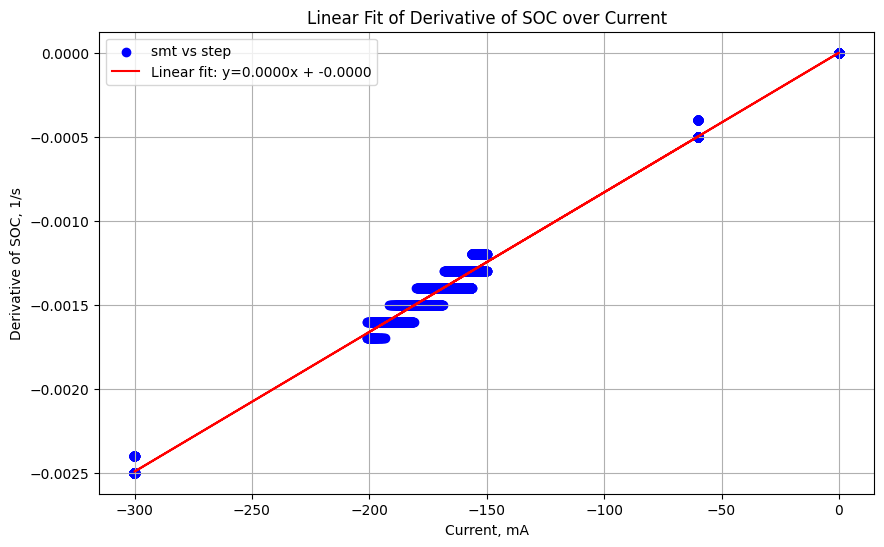

The slope of the linear fit (derivative) is: 8.310036415632977e-06
Average current is: -139.69935260840265
Transfered_Charge is: 12023643.880299998


In [14]:
file = data_HPPC_2_expanded
# Calculate the derivative of SOC over Current
derivative_SOC = np.diff(file['SOC'])

# Filter the values where derivative_SOC_over_Current is in the range [0, -0.003]
mask = (derivative_SOC <= 0.05) & (derivative_SOC >= -0.05)

# 3. Plot U_r over applied I
y_plot = derivative_SOC[mask]
x_plot = file['Current'][1:][mask]
print(x_plot.size,y_plot.size)

# Perform linear fit passing through (0,0)
coefficients = np.polyfit(x_plot.astype(np.float64), y_plot.astype(np.float64), 1)
slope = coefficients[0]
intercept = coefficients[1]

# Define the variable derivative as the slope of the fit
derivative = slope

# Plot the linear fit
plt.figure(figsize=(10, 6))
plt.scatter(x_plot, y_plot, color='blue', label='smt vs step')
plt.plot(x_plot, slope * x_plot + intercept, color='red', label=f'Linear fit: y={slope:.4f}x + {intercept:.4f}')
plt.xlabel('Current, mA')
plt.ylabel('Derivative of SOC, 1/s')
plt.title('Linear Fit of Derivative of SOC over Current')
plt.legend()
#plt.ylim([-0.03, 0.03])
plt.grid(True)
plt.show()


current_mean = np.mean(file["Current"])
charge_transfered = current_mean * len(file["Current"])
print(f"The slope of the linear fit (derivative) is: {derivative}")
print(f"Average current is: {current_mean}")
print(f"Transfered_Charge is: {abs(charge_transfered)}")


##### Charging process

38754 38754


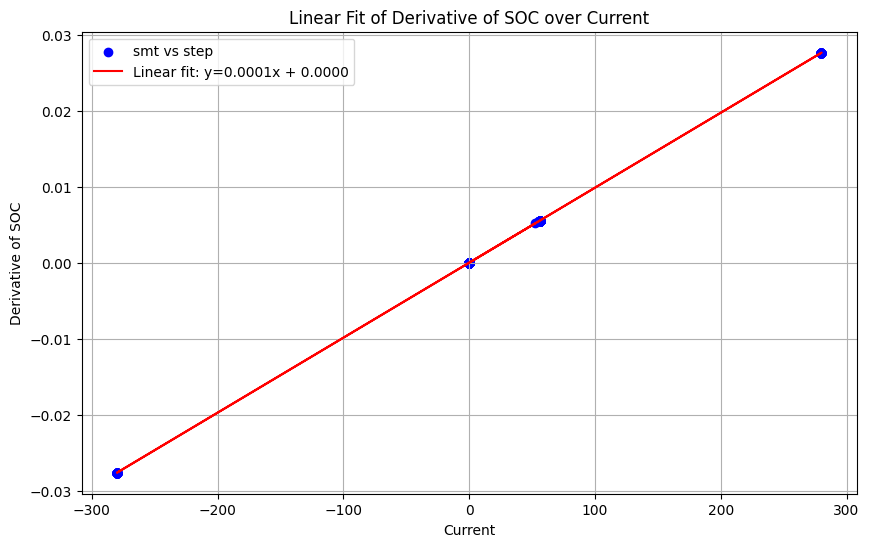

The slope of the linear fit (derivative) is: 9.871026774620857e-05
Average current is: 26.14026156237905
Transfered_Charge is: 1013065.8368500001


In [15]:
file = data_HPPC_1_expanded
# Calculate the derivative of SOC over Current
derivative_SOC = np.diff(file['SOC'])

# Filter the values where derivative_SOC_over_Current is in the range [0, -0.003]
mask = (derivative_SOC <= 0.05) & (derivative_SOC >= -0.05)

# 3. Plot U_r over applied I
y_plot = derivative_SOC[mask]
x_plot = file['Current'][1:][mask]
print(x_plot.size,y_plot.size)

# Perform linear fit passing through (0,0)
coefficients = np.polyfit(x_plot.astype(np.float64), y_plot.astype(np.float64), 1)
slope = coefficients[0]
intercept = coefficients[1]

# Define the variable derivative as the slope of the fit
derivative = slope

# Plot the linear fit
plt.figure(figsize=(10, 6))
plt.scatter(x_plot, y_plot, color='blue', label='smt vs step')
plt.plot(x_plot, slope * x_plot + intercept, color='red', label=f'Linear fit: y={slope:.4f}x + {intercept:.4f}')
plt.xlabel('Current')
plt.ylabel('Derivative of SOC')
plt.title('Linear Fit of Derivative of SOC over Current')
plt.legend()
#plt.ylim([-0.03, 0.03])
plt.grid(True)
plt.show()


current_mean = np.mean(file["Current"])
charge_transfered = current_mean * len(file["Current"])
print(f"The slope of the linear fit (derivative) is: {derivative}")
print(f"Average current is: {current_mean}")
print(f"Transfered_Charge is: {abs(charge_transfered)}")


##### Result
We observe that the slope of the relationship between applied current and changes in State of Charge (SoC) varies across different data sets. Additionally, an unusual finding is that the amount of charge transferred during both the charging and discharging processes differs significantly — by a factor of ten. This discrepancy raises questions about the consistency and reliability of the measurements.

##### Slope Table

To determine which slope should be utilized for our analysis, the same calculations were conducted for all available data files. The results of this assessment are compiled in the following table, which presents the slopes for each file. This comparative analysis will aid in identifying the most appropriate slope to use in our calculations moving forward.

In [17]:
slopes = []
for file_name in test_files +  [chg_file, dhg_file]:
    #print(file_name)
    file = get_expanded_HPPC_data(file_name, dataframes, data_OCV)
    # Calculate the derivative of SOC over Current
    derivative_SOC = np.diff(file['SOC'])

    # Filter the values where derivative_SOC_over_Current is in the range [0, -0.003]
    mask = (derivative_SOC <= 0.05) & (derivative_SOC >= -0.05)

    # 3. Plot U_r over applied I
    y_plot = derivative_SOC[mask]
    x_plot = file['Current'][1:][mask]

    # Perform linear fit passing through (0,0)
    coefficients = np.polyfit(x_plot.astype(np.float64), y_plot.astype(np.float64), 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    slopes.append(slope)

#print(slopes)

h:\My Drive\вуз\Masters\3 semester\Hackathon Huawei\importing_functions.py:144: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  step_values = hppc_df_cleaned['Step'].fillna(0).infer_objects(copy=False).values
h:\My Drive\вуз\Masters\3 semester\Hackathon Huawei\importing_functions.py:144: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  step_values = hppc_df_cleaned['Step'].fillna(0).infer_objects(copy=False).values


In [18]:
# Print values rounded to 3 significant digits
formatted_slopes = [f"{slope:.3g}" for slope in slopes]
print(formatted_slopes)
print((test_files + [chg_file, dhg_file])[-1])

['9.91e-05', '9.92e-05', '9.92e-05', '9.91e-05', '9.92e-05', '9.91e-05', '9.9e-05', '9.89e-05', '9.87e-05', '8.31e-06']
EVE_HPPC_1_25degree_DSG-injectionTemplate.xlsx


For the time being, we will assume that the HPPC discharge file is corrupted and cannot be used for our analysis. Notably, all other files exhibit a similar relationship between the change in State of Charge (d(SoC)) and the applied current. 

To facilitate the conversion of current into the SoC derivative, we will take the average dependence observed across the usable files. This average relationship will serve as a reliable basis for our calculations moving forward, allowing us to estimate d(SoC) from the current applied to the battery.

In [19]:
slopes = np.array(slopes)
# Filter the values between 8e-5 and 1e-4
filtered_values = slopes[(slopes >= 8e-5) & (slopes <= 1e-4)]

# Calculate the mean of the filtered values
derivative =  np.mean(filtered_values)
print(derivative)

9.906577834217813e-05


##### Evaluation with SoC[0] known

To evaluate the accuracy of our estimation, we will select a Test Data data file and analyze how the State of Charge (SoC) derivative measured via current compares to the actual SoC derivative. 

1. **Calculate the Estimated SoC**:  
   Using the relationship established between the current and the SoC derivative, we will compute the estimated SoC (\( \text{SoC}_{\text{estimated}} \)) based on the applied current.

2. **Compare with Real SoC**:  
   We will plot \( \text{SoC}_{\text{estimated}} \) against the real SoC (\( \text{SoC}_{\text{real}} \)) on a graph. For this analysis, we will assume that we know the initial SoC with high precision and will directly copy it from the actual measurements.

This comparison will allow us to visually assess how closely the estimated SoC aligns with the real SoC, providing insights into the effectiveness of our current-based estimation method.


In [20]:
def current_integral(current, initial_point, multiplicator):
    integral = np.zeros_like(current)
    integral[0] = initial_point
    integral[1:] = np.cumsum(current[1:] * multiplicator) + initial_point
    return integral

235795 235795


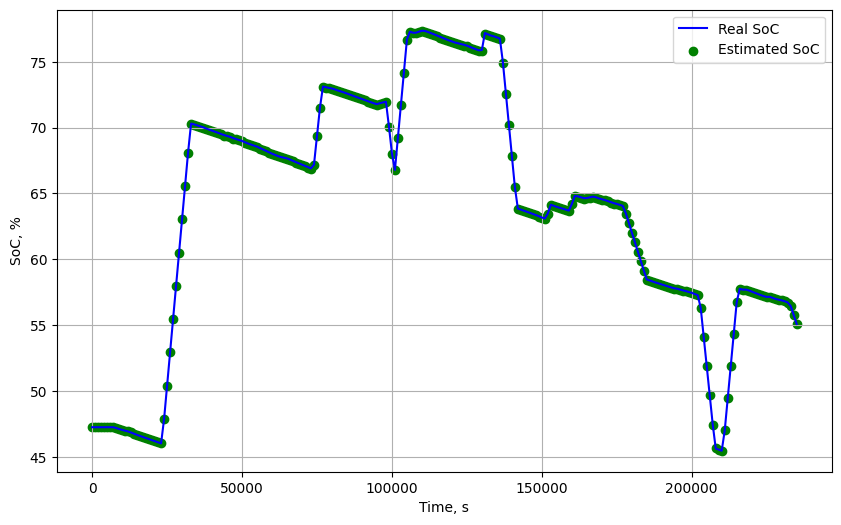

In [21]:
file = data_HPPC_3_expanded
#derivative = 1e-4
# 3. Plot U_r over applied I
y_plot = file['SOC'] 
# Initialize y_plot1 with the first value of SOC

# Calculate the remaining values using cumulative sum
y_plot1 = current_integral(file['Current'], file['SOC'][0], derivative)
x_plot = file['Step']
print(x_plot.size,y_plot.size)
plt.figure(figsize=(10, 6))
plt.plot(x_plot[::1000], y_plot[::1000], color='blue', label='Real SoC')
plt.scatter(x_plot[::1000], y_plot1[::1000], color='green', label='Estimated SoC')
plt.xlabel('Time, s')
plt.ylabel('SoC, %')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

##### Overview of Part 3

The results of our analysis are quite impressive. Both the average and maximum errors are within acceptable ranges, indicating that our estimation method performs well. The primary factor that differentiates the results from an ideal outcome is the accurate determination of the initial State of Charge (\( \text{SoC}[0] \)) or a more extensive SoC measurement at any given data point.

To improve our estimation of \( \text{SoC}[0] \), we initially considered using the voltage measurement at the initial point where no current is applied. However, as highlighted in the previous analysis, the relationship is not straightforward, and we cannot simply take \( \text{SoC}(U[\text{Voltage}[0]) \) as the sole basis for our estimation.

Given these complexities, it is clear that we need to adopt a different approach to accurately determine \( \text{SoC}[0] \). We will explore this alternative method in the subsequent section, ensuring that our estimation aligns more closely with the actual conditions observed during the charging and discharging processes.



### 4. **Initial SoC Estimation**

##### Additional functions

To enhance the efficiency of the conversion from State of Charge (SoC) to open-circuit voltage (\( U_{ocp} \)), we will optimize the computation by utilizing the NumPy library. This will allow for faster array operations and calculations compared to traditional looping methods.

In [22]:
def soc_to_u_ocp(currents, socs, interp_func_charge, interp_func_discharge):
    # Determine charge-discharge indicators based on current
    charge_discharge_indicator = np.where(currents > 0, 1, np.where(currents < 0, -1, 0))
    
    # Initialize U_ocp_values with the same shape as socs
    U_ocp_values = np.zeros_like(socs, dtype=float) + interp_func_charge(socs[0])
    
    # Calculate U_ocp for charging and discharging
    U_ocp_charge = interp_func_charge(socs)
    U_ocp_discharge = interp_func_discharge(socs)
    
    # Use boolean indexing to assign U_ocp values
    U_ocp_values[charge_discharge_indicator == 1] = U_ocp_charge[charge_discharge_indicator == 1]
    U_ocp_values[charge_discharge_indicator == -1] = U_ocp_discharge[charge_discharge_indicator == -1]
    
    # Handle zero current case by forward filling the last U_ocp value
    zero_current_indices = np.where(charge_discharge_indicator == 0)[0]
    if zero_current_indices.size > 0:
        # Forward fill the last U_ocp value
        last_U_ocp = np.zeros_like(socs, dtype=float)
        last_U_ocp[0] = U_ocp_values[0]
        for i in range(1, len(socs)):
            if charge_discharge_indicator[i] == 0:
                last_U_ocp[i] = last_U_ocp[i - 1]
            else:
                last_U_ocp[i] = U_ocp_values[i]
        U_ocp_values[zero_current_indices] = last_U_ocp[zero_current_indices]
    
    return U_ocp_values


In addition to optimizing the conversion from State of Charge (SoC) to open-circuit voltage (\( U_{ocp} \)), we have also defined loss metrics that will serve as benchmarks for comparison against our calculated arrays.

In [23]:
def calculate_losses(array1, array2):
    """
    Calculate the squared L1 loss (Mean Absolute Error) and L2 loss (Mean Squared Error) between two numpy arrays.
    
    Args:
        array1 (np.array): First numpy array.
        array2 (np.array): Second numpy array.
        
    Returns:
        tuple: The squared L1 loss and L2 loss between the two arrays.
    """
    l1_loss = np.mean(np.abs(array1 - array2))
    l2_loss = np.mean((array1 - array2) ** 2)
    return l1_loss ** 2, l2_loss

##### Analysis

This analysis is predicated on the assumption that the error between the measured voltage and the estimated open-circuit voltage (\( U_{ocp}(\text{SoC}_{\text{estim}}) \)) will reach its minimum when \( \text{SoC}_{\text{estim}}[0] \) equals the actual initial State of Charge (\( \text{SoC}[0] \)). 

From our previous analyses, we have a reasonably good understanding of the shape of the SoC curve. However, we are currently uncertain about the vertical shift of this curve. Our goal is to determine this shift by using the mentioned assumption.


In [24]:
file = data_HPPC_3_expanded
initial_socs = np.arange(1, 100)
errors_L1 = []
errors_L2 = []
for initial_soc in initial_socs:
    estimated_socs = current_integral(file['Current'], initial_soc, derivative)
    estimated_u_ocp = soc_to_u_ocp(file['Current'], estimated_socs, interp_func_charge, interp_func_discharge)
    error_L1, error_L2 = calculate_losses(estimated_u_ocp, file['Voltage'])
    errors_L1.append(error_L1)
    errors_L2.append(error_L2)
real_error_L1, real_error_L2 = calculate_losses(file['U_ocp'], file['Voltage'])
# Find the minimum value in the errors array and the corresponding initial_soc value
min_error_L1 = np.min(errors_L1)
min_error_index_L1 = np.argmin(errors_L1)
corresponding_initial_soc_L1 = initial_socs[min_error_index_L1]
min_error_L2 = np.min(errors_L2)
min_error_index_L2 = np.argmin(errors_L2)
corresponding_initial_soc_L2 = initial_socs[min_error_index_L2]

##### L1 error

Error is  1.7563988447328995


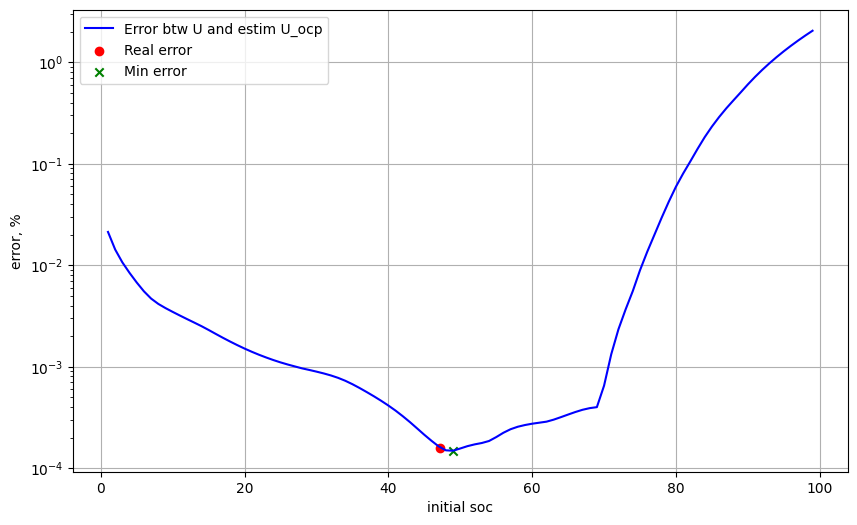

In [25]:
errors = errors_L1
real_error = real_error_L1
corresponding_initial_soc = corresponding_initial_soc_L1
min_error = min_error_L1

plt.figure(figsize=(10, 6))
plt.plot(initial_socs, errors, color='blue', label='Error btw U and estim U_ocp')
plt.scatter(file['SOC'][0], real_error, color='red', label='Real error')
plt.scatter(corresponding_initial_soc, min_error, color='green', label='Min error', marker='x')
plt.xlabel('initial soc')
plt.ylabel('error, %')
plt.title('')
plt.legend()
plt.grid(True)
plt.yscale('log')
print('Error is ', abs(file['SOC'][0] - corresponding_initial_soc))
plt.show()

##### L2 error

Error is  1.7563988447328995


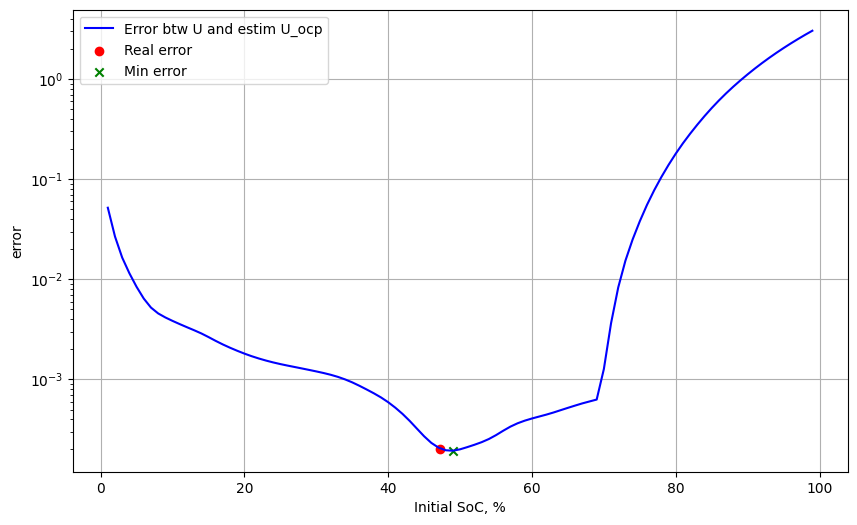

In [26]:
errors = errors_L2
real_error = real_error_L2
corresponding_initial_soc = corresponding_initial_soc_L2
min_error = min_error_L2

plt.figure(figsize=(10, 6))
plt.plot(initial_socs, errors, color='blue', label='Error btw U and estim U_ocp')
plt.scatter(file['SOC'][0], real_error, color='red', label='Real error')
plt.scatter(corresponding_initial_soc, min_error, color='green', label='Min error', marker='x')
plt.xlabel('Initial SoC, %')
plt.ylabel('error')
plt.title('')
plt.legend()
plt.grid(True)
plt.yscale('log')
print('Error is ', abs(file['SOC'][0] - corresponding_initial_soc))
plt.show()

##### Table through all the files

In [27]:
error_over_files_L1 = []
error_over_files_L2 = []
maximum_absolute_value = []
root_mean_square_value = []
for file_name in test_files:
    file = get_expanded_HPPC_data(file_name, dataframes, data_OCV)
    initial_socs = np.arange(1, 100)
    errors_L1 = []
    errors_L2 = []
    for initial_soc in initial_socs:
        estimated_socs = current_integral(file['Current'], initial_soc, derivative)
        estimated_u_ocp = soc_to_u_ocp(file['Current'], estimated_socs, interp_func_charge, interp_func_discharge)
        error_L1, error_L2 = calculate_losses(estimated_u_ocp, file['Voltage'])
        errors_L1.append(error_L1)
        errors_L2.append(error_L2)
    real_error_L1, real_error_L2 = calculate_losses(file['U_ocp'], file['Voltage'])
    # Find the minimum value in the errors array and the corresponding initial_soc value
    min_error_L1 = np.min(errors_L1)
    min_error_index_L1 = np.argmin(errors_L1)
    corresponding_initial_soc_L1 = initial_socs[min_error_index_L1]
    min_error_L2 = np.min(errors_L2)
    min_error_index_L2 = np.argmin(errors_L2)
    corresponding_initial_soc_L2 = initial_socs[min_error_index_L2]
    error_over_files_L1.append((file['SOC'][0] - corresponding_initial_soc_L1))
    error_over_files_L2.append((file['SOC'][0] - corresponding_initial_soc_L2))
    
    # Find errors for absolute value and root MSE
    estimated_socs = current_integral(file['Current'], corresponding_initial_soc_L2, derivative)
    error_L1, error_L2 = np.sqrt(calculate_losses(estimated_socs, file['SOC']))
    maximum_absolute_value.append(error_L1)
    root_mean_square_value.append(error_L2)

print(error_over_files_L1)
print(error_over_files_L2)

print('MaxAE ', maximum_absolute_value)
print('RMSE ', root_mean_square_value)


[-7.0, -1.7563988447328995, 0.0, 0.6313236751522027, -4.0, -7.714997006878903, 1.075724885884803, 1.0]
[-3.0, -1.7563988447328995, -1.0, -0.36867632484779733, -4.0, -3.714997006878903, 0.07572488588480297, 0.0]
MaxAE  [2.933395400017986, 1.728599011250386, 0.9066754144087555, 0.341485630247604, 4.158100133371004, 3.8347281065914225, 0.0638697580634871, 0.028384463716864573]
RMSE  [2.9335565007835087, 1.728685968693826, 0.908768132691726, 0.342038272759336, 4.158869908426101, 3.8355912573396918, 0.07091356539533326, 0.03712637577045566]


##### Result

The analysis indicates that the L2 error metric yields superior performance compared to the L1 error metric. Therefore, we will adopt the L2 error as our primary measure for evaluating the accuracy of our estimations moving forward.

Furthermore, our initial assumption that the error between the measured voltage and the estimated open-circuit voltage (\( U_{ocp}(\text{SoC}_{\text{estim}}) \)) will reach its minimum when \( \text{SoC}_{\text{estim}}[0] \) equals the actual initial State of Charge (\( \text{SoC}[0] \)) has proven to be correct

### 5. Additional **LSTM Model for \( U_{ocp} \) Estimation** (not provided to reach maximum speed and minimize the amount of importing libraries)